In [1]:
import pandas as pd
import numpy as np
import torch
import gpytorch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from torch.utils.data import DataLoader, Dataset

In [2]:
import os

date = '24-08-2024'
version = 'v1'
run_id = date + '_' + version

# Create a folder if it doesn't exist
folder_path = f'{run_id}'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA available?:", torch.cuda.is_available())
print("Number of GPUs available:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available?: True
Number of GPUs available: 1
Current GPU: 0
GPU Name: NVIDIA GeForce GTX 1660 SUPER


In [4]:
class PollutionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y.values, dtype=torch.float32, device=device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:

dataset = pd.read_csv('../Dataset/dataset.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])

X = dataset.drop(columns=['Date', 'PM2.5', 'Nombre_Estacion', 'Clave_Estacion'])  # Adjust columns as needed
y = dataset['PM2.5']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply quantile transformation to X_train and X_test
transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

pollution_dataset_train = PollutionDataset(X_train, y_train)
batch_size = 512  # Adjust batch size as needed
train_loader = DataLoader(pollution_dataset_train, batch_size=batch_size, shuffle=True)

In [6]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())  # RBF kernel is common for continuous data

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(None, None, likelihood).to(device)

In [7]:
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Marginal Log Likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
n_epochs = 100
model.train()
likelihood.train()
for epoch in range(n_epochs):
    for X_batch, y_batch in train_loader:
        # print(X_batch.device, y_batch.device)
        model.set_train_data(X_batch, y_batch, strict=False)
        # print(next(model.parameters()).device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
    
    # if (epoch + 1) % 10 == 0:
    #     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #         epoch + 1, n_epochs, loss.item(),
    #         model.covar_module.base_kernel.lengthscale.item(),
    #         model.likelihood.noise.item()
    #     ))

    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        epoch + 1, n_epochs, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))

Iter 1/100 - Loss: 285.615   lengthscale: 0.891   noise: 0.850
Iter 2/100 - Loss: 198.451   lengthscale: 1.166   noise: 0.989
Iter 3/100 - Loss: 129.564   lengthscale: 1.408   noise: 1.108
Iter 4/100 - Loss: 72.764   lengthscale: 1.594   noise: 1.222
Iter 5/100 - Loss: 162.523   lengthscale: 1.739   noise: 1.338
Iter 6/100 - Loss: 77.099   lengthscale: 1.856   noise: 1.461
Iter 7/100 - Loss: 94.326   lengthscale: 1.955   noise: 1.590
Iter 8/100 - Loss: 76.548   lengthscale: 2.037   noise: 1.725
Iter 9/100 - Loss: 80.856   lengthscale: 2.107   noise: 1.868
Iter 10/100 - Loss: 67.576   lengthscale: 2.169   noise: 2.016
Iter 11/100 - Loss: 45.499   lengthscale: 2.222   noise: 2.169
Iter 12/100 - Loss: 62.082   lengthscale: 2.269   noise: 2.327
Iter 13/100 - Loss: 43.673   lengthscale: 2.311   noise: 2.490
Iter 14/100 - Loss: 37.170   lengthscale: 2.347   noise: 2.656
Iter 15/100 - Loss: 30.143   lengthscale: 2.378   noise: 2.826
Iter 16/100 - Loss: 52.674   lengthscale: 2.403   noise: 3.0

# Saving the model

In [8]:
import joblib

# Save the model parameters
joblib.dump(model.state_dict(), f'{run_id}/{run_id}_model_parameters.joblib')
joblib.dump(likelihood.state_dict(), f'{run_id}/{run_id}_likelihood_parameters.joblib')

['24-08-2024_v1/24-08-2024_v1_likelihood_parameters.joblib']

# Evaluate

In [9]:
model.eval()
likelihood.eval()

test_dataset = PollutionDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_actuals = []
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        preds = likelihood(model(batch_x))
        mean = preds.mean
        
        all_preds.append(mean.cpu().numpy())
        all_actuals.append(batch_y.cpu().numpy())

# Flatten the lists of batches
predicted = np.concatenate(all_preds)
actual = np.concatenate(all_actuals)

MSE: 317.66
RMSE: 17.82
R2: 0.30
MAE: 10.13


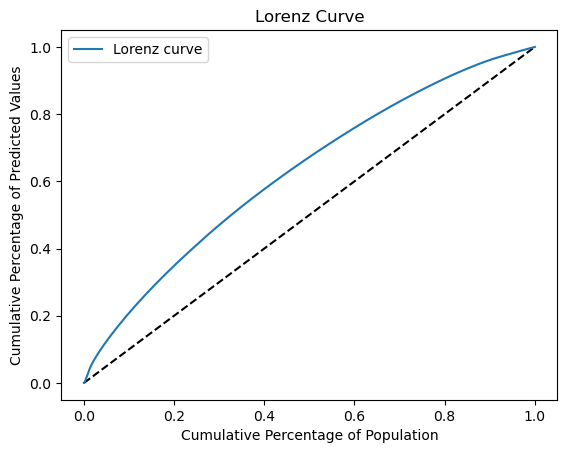

In [12]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)
mae = mean_absolute_error(actual, predicted)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {np.sqrt(mse):.2f}')
print(f'R2: {r2:.2f}')
print(f'MAE: {mae:.2f}')

import matplotlib.pyplot as plt

# Sort the actual and predicted values in ascending order
sorted_actual = np.sort(actual)
sorted_predicted = np.sort(predicted)

# Calculate the cumulative sum of actual and predicted values
cumulative_actual = np.cumsum(sorted_actual) / np.sum(sorted_actual)
cumulative_predicted = np.cumsum(sorted_predicted) / np.sum(sorted_predicted)

# Plot the Lorenz curve
plt.plot([0, 1], [0, 1], 'k--')  # 45-degree line
plt.plot(cumulative_actual, cumulative_predicted, label='Lorenz curve')
plt.xlabel('Cumulative Percentage of Population')
plt.ylabel('Cumulative Percentage of Predicted Values')
plt.title('Lorenz Curve')
plt.legend()
plt.show()

In [14]:
dataset

,Date,CO,NO,NO2,NOX,O3,PM10,PM2.5,Atmospheric Pressure,Precipitation,Relative Humidity,SO2,Solar Radiation,Temperature,Wind Speed,Wind Direction,Nombre_Estacion,Clave_Estacion,Latitude,Longitude
0,2022-01-01 00:00:00,2.36,19.8,48.4,68.0,5.0,142.0,111.00,715.7,0.0,59.0,4.0,0.000,21.65,6.5,285.0,NORESTE3 PESQUERIA,Pesqueria,25.791343,-100.078176
1,2022-01-01 01:00:00,2.29,10.8,44.5,55.1,6.0,168.0,112.16,715.5,0.0,59.0,4.6,0.000,21.21,7.1,284.0,NORESTE3 PESQUERIA,Pesqueria,25.791343,-100.078176
2,2022-01-01 02:00:00,2.71,28.3,47.1,75.2,4.0,203.0,139.31,715.4,0.0,62.0,5.9,0.000,21.21,7.7,290.0,NORESTE3 PESQUERIA,Pesqueria,25.791343,-100.078176
3,2022-01-01 03:00:00,2.31,19.6,42.1,61.5,5.0,262.0,177.68,715.1,0.0,59.0,5.5,0.000,20.44,8.2,294.0,NORESTE3 PESQUERIA,Pesqueria,25.791343,-100.078176
4,2022-01-01 04:00:00,1.85,13.0,39.5,52.5,4.0,185.0,134.21,715.1,0.0,59.0,4.9,0.000,19.80,8.1,287.0,NORESTE3 PESQUERIA,Pesqueria,25.791343,-100.078176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205800,2023-08-17 19:00:00,0.53,3.1,8.2,11.2,40.0,108.0,17.00,705.4,0.0,60.0,3.5,0.056,36.67,14.5,66.0,SURESTE TEC NL,Tec de Nuevo León,25.668270,-100.249580
205801,2023-08-17 20:00:00,0.56,2.9,9.9,12.7,36.0,59.0,17.00,705.8,0.0,60.0,3.5,0.000,35.27,12.6,64.0,SURESTE TEC NL,Tec de Nuevo León,25.668270,-100.249580
205802,2023-08-17 21:00:00,0.57,3.0,10.3,13.2,33.0,56.0,17.00,706.3,0.0,60.0,3.0,0.000,34.57,11.6,69.0,SURESTE TEC NL,Tec de Nuevo León,25.668270,-100.249580
205803,2023-08-17 22:00:00,0.74,9.8,21.1,30.9,19.0,54.0,17.00,706.8,0.0,60.0,2.8,0.000,33.99,11.9,88.0,SURESTE TEC NL,Tec de Nuevo León,25.668270,-100.249580
